# 使用RNN实现文本分类

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import tensorflow.keras as keras
print(tf.__version__)

1.13.0-rc1


## 使用tensorflow_datasets 构造输入数据

```
pip install tensorflow_datasets
```

In [4]:
import tensorflow_datasets as tfds

dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


W0814 09:00:30.314590 140735620006784 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow_datasets/core/file_format_adapter.py:209: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset imdb_reviews downloaded and prepared to /Users/momo/tensorflow_datasets/imdb_reviews/subwords8k/0.1.0. Subsequent calls will reuse this data.


W0814 09:01:58.746002 140735620006784 dataset_builder.py:439] Warning: Setting shuffle_files=True because split=TRAIN and shuffle_files=None. This behavior will be deprecated on 2019-08-06, at which point shuffle_files=False will be the default for all splits.


In [5]:
train_dataset, test_dataset = dataset['train'], dataset['test']

获取tokenizer对象，用进行字符处理级id转换（这里先转换成subword，再转换为id）等操作

In [6]:
tokenizer = info.features['text'].encoder
print('vocabulary size: ', tokenizer.vocab_size)

vocabulary size:  8185


tokenizer 对象的编码和解码

In [7]:
sample_string = 'Hello word , Tensorflow'
tokenized_string = tokenizer.encode(sample_string)
print('tokened id: ', tokenized_string)

# 解码回原字符串
src_string = tokenizer.decode(tokenized_string)
print('original string: ', src_string)

tokened id:  [4025, 222, 2621, 1199, 6307, 2327, 2934]
original string:  Hello word , Tensorflow


解出每个subword

In [8]:
for t in tokenized_string:
    print(str(t)+'->['+tokenizer.decode([t])+ ']')

4025->[Hell]
222->[o ]
2621->[word]
1199->[ , ]
6307->[Ten]
2327->[sor]
2934->[flow]


构建批次训练集

In [9]:
BUFFER_SIZE=10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, train_dataset.output_shapes)

test_dataset = test_dataset.padded_batch(BATCH_SIZE, test_dataset.output_shapes)

## 模型构建

因为此处的句子是变长的，所以只能使用序列模型，而不能使用keras的函数api

In [10]:
# def get_model():
#     inputs = tf.keras.Input((1240,))
#     emb = tf.keras.layers.Embedding(tokenizer.vocab_size, 64)(inputs)
#     h1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(emb)
#     h1 = tf.keras.layers.Dense(64, activation='relu')(h1)
#     outputs = tf.keras.layers.Dense(1, activation='sigmoid')(h1)
#     model = tf.keras.Model(inputs, outputs)
#     return model

def get_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(tokenizer.vocab_size, 64),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [11]:
model = get_model()
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


W0814 09:55:45.789745 140735620006784 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/resource_variable_ops.py:435: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


## 模型训练

In [19]:
history = model.fit(train_dataset, steps_per_epoch=20, epochs=10, validation_data=test_dataset, validation_steps=5)

Epoch 1/10
20/20 [==============================] - 55s 3s/step - loss: 0.6931 - acc: 0.5164 - val_loss: 0.6924 - val_acc: 0.5437
Epoch 2/10
20/20 [==============================] - 45s 2s/step - loss: 0.6891 - acc: 0.5633 - val_loss: 0.6786 - val_acc: 0.5219
Epoch 3/10
20/20 [==============================] - 42s 2s/step - loss: 0.6788 - acc: 0.6008 - val_loss: 0.6578 - val_acc: 0.6250
Epoch 4/10
20/20 [==============================] - 47s 2s/step - loss: 0.6101 - acc: 0.6734 - val_loss: 0.5729 - val_acc: 0.7188
Epoch 5/10
20/20 [==============================] - 44s 2s/step - loss: 0.5137 - acc: 0.7531 - val_loss: 0.5175 - val_acc: 0.7625
Epoch 6/10
20/20 [==============================] - 44s 2s/step - loss: 0.5687 - acc: 0.7219 - val_loss: 0.5470 - val_acc: 0.7250
Epoch 7/10
20/20 [==============================] - 41s 2s/step - loss: 0.5218 - acc: 0.7406 - val_loss: 0.5597 - val_acc: 0.7250
Epoch 8/10
20/20 [==============================] - 37s 2s/step - loss: 0.4938 - acc: 0.78

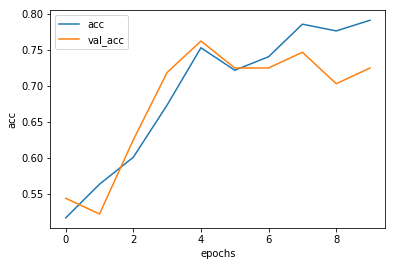

In [21]:
# 查看训练过程
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel('epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, 'acc')

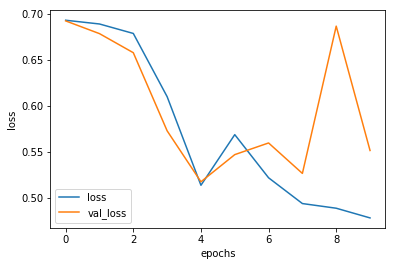

In [22]:
plot_graphs(history, 'loss')

In [24]:
test_loss, test_acc = model.evaluate(test_dataset, steps=1)
print('test loss: ', test_loss)
print('test acc: ', test_acc)

1/1 [==============================] - 1s 680ms/step - loss: 0.6696 - acc: 0.6406
test loss:  0.6695894002914429
test acc:  0.640625


**上述模型不会mask掉序列的padding，所以如果在有padding的寻列上训练，测试没有padding的序列时可能有所偏差。**

In [25]:
def pad_to_size(vec, size):
    zeros = [0] * (size-len(vec))
    vec.extend(zeros)
    return vec

def sample_predict(sentence, pad=False):
    
    tokened_sent = tokenizer.encode(sentence)
    if pad:
        tokened_sent = pad_to_size(tokened_sent, 64)
    pred = model.predict(tf.expand_dims(tokened_sent, 0))
    return pred

In [27]:
# 没有padding的情况
sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

TypeError: sample_predict() got an unexpected keyword argument 'steps'